In [1]:
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from order_book import OrderBook
from probs import MidpriceUp, BidOrderExecution, MakingSpread, StopLossReaching


import matplotlib


In [2]:
data_path = Path('../data')

In [10]:
all_data = []
paths = sorted(list(data_path.glob('BYBIT.ws*')), key=lambda x: float(x.name.split('.')[-1]))[:27]

for path in tqdm(paths):
    with open(path, 'r') as f:
        next(f)
        
        _data = [json.loads(i.split(': ')[-1]) for i in f.readlines()]
        _data = [i for i in _data if 'topic' in i]
        all_data.extend([i for i in _data if 'BNBUSDT' in i['topic'] ])

    

  0%|          | 0/27 [00:00<?, ?it/s]

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [4]:
asks_cols = [f'ASK{i}' for i in range(25)]
vasks_cols = [f'VASK{i}' for i in range(25)]

bids_cols = [f'BID{i}' for i in range(25)]
vbids_cols = [f'VBID{i}' for i in range(25)]

csv_cols = asks_cols + vasks_cols + bids_cols + vbids_cols

snaps = all_data[1]['data']['order_book']

asks = {float(i['price']): i['size'] for i in snaps if i['side'] == 'Sell'}
bids = {float(i['price']): i['size'] for i in snaps if i['side'] == 'Buy'}

ob = OrderBook()
ob.asks = asks
ob.bids = bids

ask_arrivals = []
bid_arrivals = []
ask_cancels = []
bid_cancels = []
market = []

data_df = []

for data in all_data[3:]:
    
    d = {}
    asks_d = ob.asks.to_dict()
    bids_d = ob.bids.to_dict()
    asks, vasks = asks_d.keys(), asks_d.values()
    bids, vbids = bids_d.keys(), bids_d.values()

    d.update(dict(zip(bids_cols, bids)))
    d.update(dict(zip(asks_cols, asks)))
    d.update(dict(zip(vasks_cols, vasks)))
    d.update(dict(zip(vbids_cols, vbids)))
    
    data_df.append(d)
    
    if 'orderBook' in data['topic']:
        
        bbid = float(data['data']['bid1_id']) / 1e6
        bask = float(data['data']['ask1_id']) / 1e6
    
        for delete in data['data']['delete']:
            if delete['side'] == 'Sell':
                del ob.asks[float(delete['price'])]
            else:
                del ob.bids[float(delete['price'])]

        for update in data['data']['update']:
            counter = bbid if update['side'] == 'Sell' else bask
            distance = int(abs(float(update['price']) * 100 - counter))
            
            side = ob.asks if update['side'] == 'Sell' else ob.bids
            q_delta = update['size'] - side[float(update['price'])]
            
            if q_delta > 0 and update['side'] == 'Sell':
                ask_arrivals.append((distance, q_delta))
                
            elif q_delta > 0 and update['side'] == 'Buy':
                bid_arrivals.append((distance, q_delta))
                
            elif q_delta < 0 and update['side'] == 'Sell':
                ask_cancels.append((distance, q_delta))
                
            elif q_delta < 0 and update['side'] == 'Buy':
                bid_cancels.append((distance, q_delta))
                
        for insert in data['data']['insert']:
            
            counter = bbid if insert['side'] == 'Sell' else bask
            distance = int(abs(float(insert['price']) * 100 - counter))
            
            if insert['side'] == 'Sell':
                ob.asks[float(insert['price'])] = float(insert['size']) 
                ask_arrivals.append((distance, float(insert['size'])))
            else:
                ob.bids[float(insert['price'])] = float(insert['size']) 
                bid_arrivals.append((distance, float(insert['size'])))
                
    else:
        
        aggregates = {}
        for trade in data['data']:
            existing = float(trade['size']) + aggregates.get(float(trade['price']), 0)
            aggregates.update({float(trade['price']): existing})

        for price, size in aggregates.items():
            market.append(size)
                
                
ask_arrivals = pd.DataFrame(ask_arrivals, columns=['i', 'size'])
bid_arrivals = pd.DataFrame(bid_arrivals, columns=['i', 'size'])
                
ask_cancels = pd.DataFrame(ask_cancels, columns=['i', 'size'])
bid_cancels = pd.DataFrame(bid_cancels, columns=['i', 'size'])



In [9]:
aggregates

{311.95: 0.01}

In [8]:
bid_arrivals.sort_values('i')

,i,size
4467,4,5.00
91426,4,146.13
198121,4,50.46
198126,4,50.50
91424,4,119.34
...,...,...
38096,1005,163.47
173281,1005,1.43
38111,1005,163.47
189381,1010,4.75


In [5]:
data_df = pd.DataFrame(data_df)
data_df['mid'] = data_df[['BID0', 'ASK0']].mean(axis=1)

In [15]:
Sm = np.mean(market)
Sl = (ask_arrivals.groupby('i').mean() + bid_arrivals.groupby('i').mean()).mean()
Sc = (ask_cancels.groupby('i').mean()+ bid_cancels.groupby('i').mean()).mean().abs() - Sm

Sl = Sl.iloc[0]

Nlia = ask_arrivals.groupby('i').count()
Nlib = bid_arrivals.groupby('i').count()

start = dt.datetime.fromtimestamp(int(all_data[2]['timestamp_e6']) / 1e6)
end = dt.datetime.fromtimestamp(int(all_data[-1]['timestamp_e6']) / 1e6)
T = (end - start).total_seconds() / 60

lamdaia = Nlia / T
lamdaib = Nlib / T

lamdaia = lamdaia['size'].values[:50]
lamdaib = lamdaib['size'].values[:50]

mu = len(market)/T * Sm/Sl

In [16]:
Qi = np.mean([
    ((bid_arrivals.groupby('i').mean() / Sl)['size'].values)[:20],
    ((ask_arrivals.groupby('i').mean() / Sl)['size'].values)[:20]
], axis=0)

thetai = (ask_cancels.groupby('i').count() + bid_cancels.groupby('i').count()).sort_index().iloc[:20]['size'].values /(T*Qi) * Sc.iloc[0]/Sl


In [17]:
(data_df['VBID0'] / data_df['VASK0']).describe()

count    232722.000000
mean          5.309726
std          52.656574
min           0.006112
25%           0.411954
50%           0.793644
75%           1.655966
max        1313.750000
dtype: float64

In [21]:
(data_df['VBID0'] / data_df['VASK0']).describe()

count    232722.000000
mean          5.309726
std          52.656574
min           0.006112
25%           0.411954
50%           0.793644
75%           1.655966
max        1313.750000
dtype: float64

In [22]:
def get_lambda(idx: int, lambdas: pd.Series):
    return lambdas[min(idx, len(lambdas) - 1)]


def get_theta(idx: int, thetas: pd.Series):
    return thetas[min(idx, len(thetas) - 1)]

In [23]:
import json
import numpy as np
from typing import Optional
from scipy.stats import binom
from tqdm.notebook import tqdm
from order_book import OrderBook
from abc import abstractmethod, ABC


class MyOrderBook(OrderBook):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def spread(self) -> float:
        assert len(self.bids) > 0 and len(self.asks) > 0
        return self.asks.index(0)[0] - self.bids.index(0)[0]

    def __repr__(self) -> str:
        ob = {k: self.to_dict()[k] for k in sorted(self.to_dict())}
        return json.dumps(ob, indent=4)

    def vbbid(self) -> float:
        return self.bids.index(0)[-1]

    def vbask(self) -> float:
        return self.asks.index(0)[-1]

    def increment_vbask(self) -> None:
        price, vol = self.asks.index(0)
        self.asks[price] = vol + Sl

    def decrement_vbask(self) -> None:
        price, vol = self.asks.index(0)

        if vol == Sl:
            del self.asks[price]
        else:
            self.asks[price] = vol - Sl

    def decrement_vbbid(self) -> None:
        price, vol = self.bids.index(0)

        if vol == Sl:
            del self.bids[price]
        else:
            self.bids[price] = vol - Sl

    def increment_vbbid(self) -> None:
        price, vol = self.bids.index(0)
        self.bids[price] = vol + Sl


class MonteCarloExperiment(ABC):
    def __init__(self, trials=10_000, verbose=False, **params) -> None:
        self.verbose = verbose
        self.trials = trials
        self.params = params

    @abstractmethod
    def reset_state(self) -> None:
        ...

    @abstractmethod
    def update_state(self) -> None:
        ...

    @abstractmethod
    def success(self) -> Optional[bool]:
        """
        Is used to detemine desirable outcome, once the conditional events are
        reached. For example: in midprice increase probability, success() must
        be called, once midprice is changing and its change is positive. In all
        other cases, it must return nothing

        Returns:
            bool (optional): whether conditional is reached and outcome is
        a desirable function returns True. Otherwise - None.
        """
        ...

    @abstractmethod
    def failure(self) -> Optional[bool]:
        """
        is used to determine events, which are recorgnised as failures
        of the monte-carlo experiment. They are important, because those events
        determine conditionals. For example: when we want to calculate the
        probability of the mid price increase, we do it conditional on the
        midprice change. In other words, we calculate probability of the next
        midprice change being positive. In that scenario, failure() function
        must return true, if midprice changed in the opposite direction.
        Otherwise, experiment must continue, until next mid price change occurs

        Returns:
            bool (optional): whether conditional is reached and the outcome is
        a undesirable. In all other cases function returns None.
        """
        ...

    def evaluate(self) -> float:
        count = 0
        trials = range(self.trials)
        trials = tqdm(trials) if self.verbose else trials

        for trial in trials:
            self.reset_state()

            while True:
                self.update_state()

                if self.success():
                    count += 1
                    break

                elif self.failure():
                    break

        return count / self.trials




class MidpriceUp(MonteCarloExperiment):
    def __init__(self, bbid_orders: int = 5, bask_orders: int = 5,
                 spread: int = 10, trials: int = 10000, verbose=False,
                 **params):
        super().__init__(trials, verbose, **params)

        self.bbid_orders = bbid_orders
        self.bask_orders = bask_orders
        self.spread = spread
        self.reset_state()

    def reset_state(self) -> None:
        self.xb = self.bbid_orders
        self.xa = self.bask_orders
        self.S = self.spread

        self.ob = MyOrderBook()
        self.ob.asks[self.spread] = self.bask_orders
        self.ob.bids[0] = self.bbid_orders

    def success(self) -> Optional[bool]:
        """
        Nescessary condition: midprice changes
        Desirable outcome:    midprice increases
        """
        if len(self.ob.bids) > 1 or len(self.ob.asks) == 0:
            return True
        
        elif self.ob.vbask() <= 0:
            return True


    def failure(self) -> Optional[bool]:
        """
        Nescessary condition: midprice changes
        Undesirable outcome:  midprice drops
        """

        # midprice decreases, if new asks get within spread
        # or when best bid level is exhausted
        if len(self.ob.asks) > 1 or len(self.ob.bids) == 0:
            return True
        
        elif self.ob.vbbid() <= 0:
            return True

    def update_state(self) -> None:
        
        lamdaia = self.params['lamdaia']
        lamdaib = self.params['lamdaib']
        mu = self.params['mu']
        theta = self.params['theta']
        
#         lamda, mu = self.params['lamda'], self.params['mu']
#         theta, lambda_ = self.params['theta'], self.params['lambda_']

        birth_inspread_ask = np.array([lamdaia[i] for i in range(1, self.S)])
        birth_inspread_bid = np.array([lamdaia[i] for i in range(1, self.S)])

        birth_bid = lamdaia[0]
        birth_ask = lamdaib[0]
        death_bid = mu + theta*self.ob.vbbid()
        death_ask = mu + theta*self.ob.vbask()
        
        pevent = np.array([birth_bid, birth_ask, death_bid, death_ask])
#         pevent = np.append(pevent, birth_inspread_ask)
#         pevent = np.append(pevent, birth_inspread_bid)
        pevent /= pevent.sum()
    

        event = np.random.choice(np.arange(len(pevent)), size=1, p=pevent)[0]

        if event == 0:
            self.ob.increment_vbbid()

        elif event == 1:
            self.ob.increment_vbask()

        elif event == 2:
            self.ob.decrement_vbbid()

        elif event == 3:
            self.ob.decrement_vbask()

        elif event >= 4 and event < 4 + self.S:
            inspread_dist = event - 3
            # price of best ask
            new_bask = self.ob.asks.index(0)[0] - inspread_dist
            self.ob.asks[new_bask] = Sl

        elif event >= 4 + self.S:

            inspread_dist = event - 3 - self.S
            # price of best bid
            new_bbid = self.ob.bids.index(0)[0] + inspread_dist
            self.ob.bids[new_bbid] = Sl
            
    def evaluate(self) -> float:
        count = 0
        trials = range(self.trials)
        trials = tqdm(trials) if self.verbose else trials

        for trial in trials:
            self.reset_state()

            while True:
                self.update_state()

                if self.success():
                    count += 1
                    break

                elif self.failure():
                    break

        return count / self.trials

In [24]:
(data_df['VBID0'] / data_df['VASK0']).describe()

count    232722.000000
mean          5.309726
std          52.656574
min           0.006112
25%           0.411954
50%           0.793644
75%           1.655966
max        1313.750000
dtype: float64

In [25]:
binance_params = {
    'mu': mu,
    'theta': thetai[0],
    'lamdaia': lamdaia,
    'lamdaib': lamdaib,
    'lambda_': lambda x: get_lambda(x, lamdai)
}


m = MidpriceUp(
    bbid_orders=Sl*8,
    bask_orders=Sl*1,
    trials=1000,
    spread=10,
    **binance_params
)
m.evaluate()

1.0

In [118]:
binance_params = {
    'mu': mu,
    'theta': thetai[0],
    'lamdaia': lamdaia,
    'lamdaib': lamdaib,
    'lambda_': lambda x: get_lambda(x, lamdai)
}


m = MidpriceUp(
    bbid_orders=Sl*8,
    bask_orders=Sl*1,
    trials=1000,
    spread=10,
    **binance_params
)
m.evaluate()

0.904

In [26]:
res = []
bid_sizes =  np.linspace(0.0006, 10, 100)
for bs in tqdm(bid_sizes):
    m = MidpriceUp(
        bbid_orders=bs * Sl,
        bask_orders=Sl,
        trials=1000,
        spread=1,
        **binance_params
    ).evaluate()
    res.append(m)
    

  0%|          | 0/100 [00:00<?, ?it/s]

In [119]:
res = []
bid_sizes =  np.linspace(0.0006, 10, 100)
for bs in tqdm(bid_sizes):
    m = MidpriceUp(
        bbid_orders=bs * Sl,
        bask_orders=Sl,
        trials=1000,
        spread=1,
        **binance_params
    ).evaluate()
    res.append(m)
    

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
import bisect

disbalance_to_prob = dict(zip(bid_sizes, res))
ind = bisect.bisect_left(bid_sizes, 0.0)
ind

0

In [28]:
data_df['disbalance'] = data_df['VBID0'] / data_df['VASK0']

In [29]:
data_df['rise_prob'] = data_df['disbalance'].apply(lambda x: res[bisect.bisect_left(bid_sizes, x) - 1])

In [30]:
data_df[['mid', 'rise_prob']].corr()

,mid,rise_prob
mid,1.00000,0.01417
rise_prob,0.01417,1.00000


In [31]:
np.corrcoef(
    data_df['mid'],
    data_df['rise_prob'].shift(1).fillna(1)
)

array([[1.       , 0.0142013],
       [0.0142013, 1.       ]])

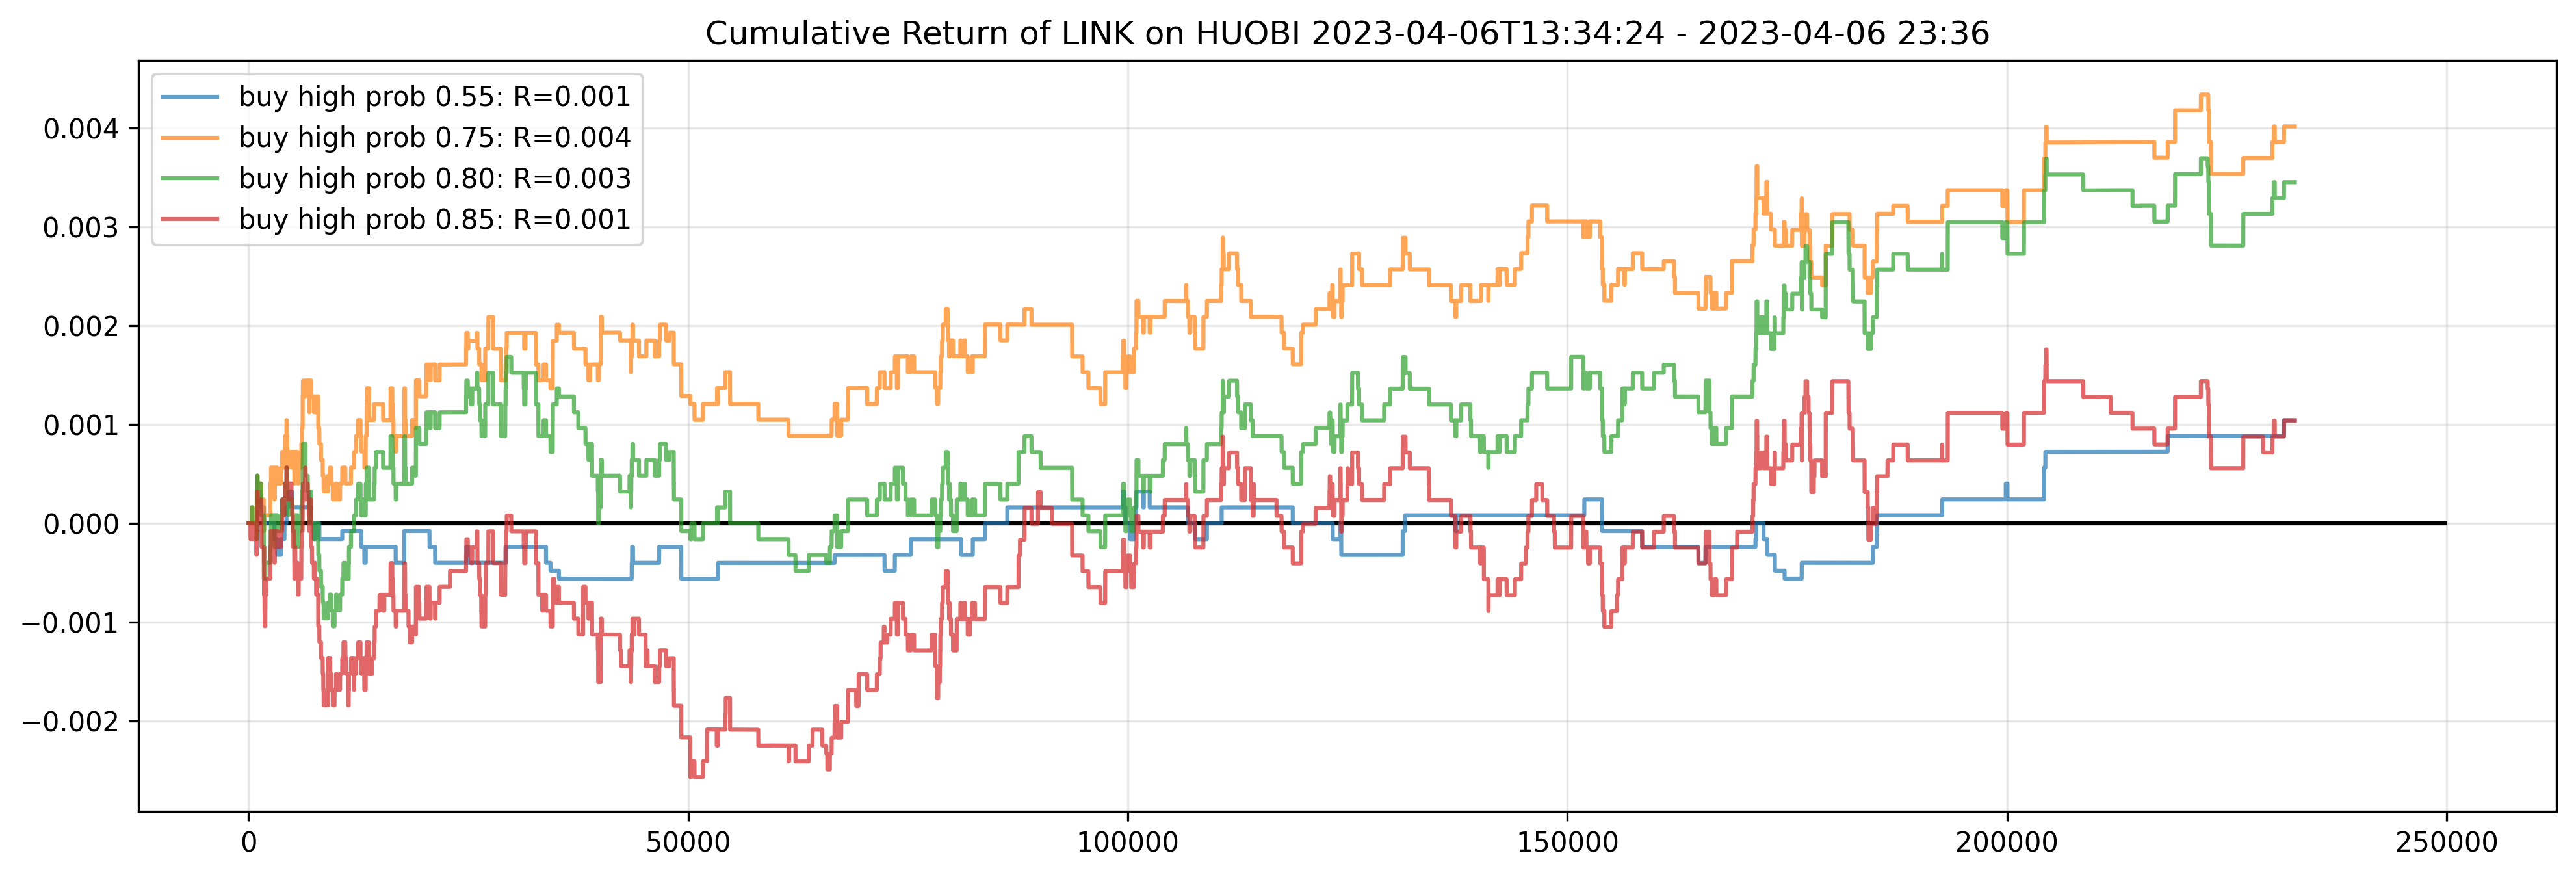

In [32]:
f, ax =plt.subplots(figsize=(16, 5), dpi=300)

benchmark = (1 + data_df['mid'].pct_change()).cumprod()
# benchmark.plot(alpha=0.3, color='black', lw=3, label='buy and hold')
ax.hlines(0, 0, 2.5e5, color='black')

for i in [0.55, 0.75, 0.8, 0.85]:
    pos = (data_df['rise_prob'] > i).astype(int)
    cp = (1 + (data_df['mid'].pct_change() *  pos)).cumprod() - benchmark
    cp.plot(alpha=0.7, label=f'buy high prob {i:.2f}: R={cp.iloc[-1]:.3f}')
    plt.grid(alpha=0.3)
    plt.legend()
    
plt.title('Cumulative Return of LINK on HUOBI 2023-04-06T13:34:24 - 2023-04-06 23:36')
plt.savefig('al')

Text(0.5, 1.0, 'Cumulative Return of EOS on Binance')

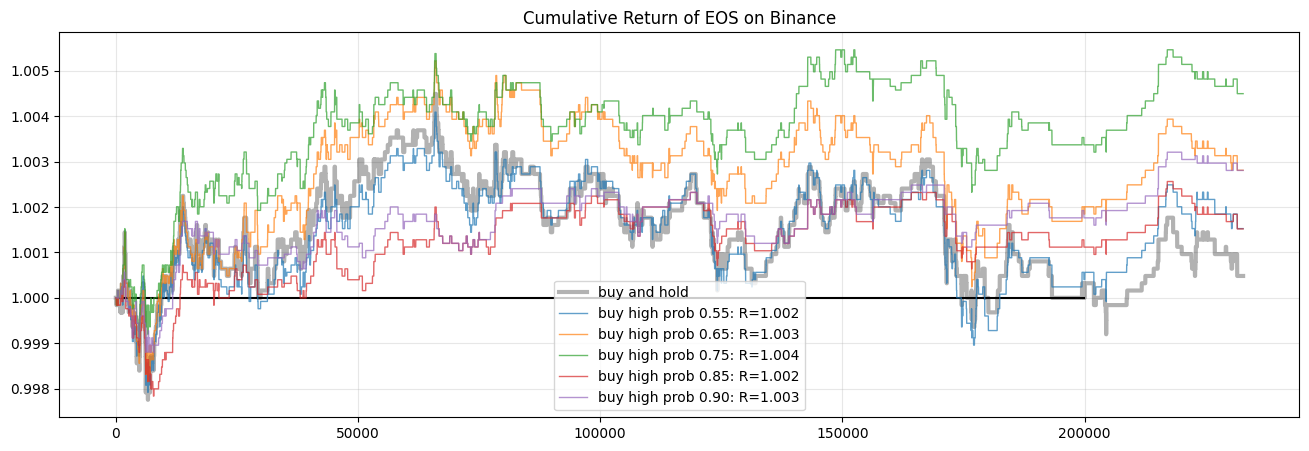

In [33]:
f, ax =plt.subplots(figsize=(16, 5))

benchmark = (1 + data_df['mid'].pct_change()).cumprod()
benchmark.plot(alpha=0.3, color='black', lw=3, label='buy and hold')
ax.hlines(1, 0, 2e5, color='black')

for i in [0.55, 0.65, 0.75, 0.85, 0.9]:
    pos = (data_df['rise_prob'] > i).astype(int)
    cp = (1 + (data_df['mid'].pct_change() *  pos)).cumprod()
    
    cp.plot(alpha=0.7, lw=1, label=f'buy high prob {i:.2f}: R={cp.iloc[-1]:.3f}')
    plt.grid(alpha=0.3)
    plt.legend()
    
plt.title('Cumulative Return of EOS on Binance')


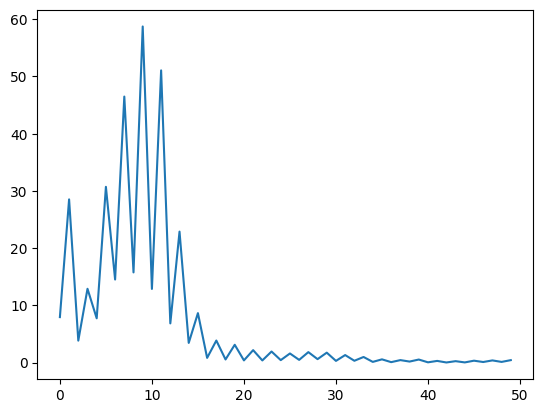

In [34]:
plt.plot(lamdaia)

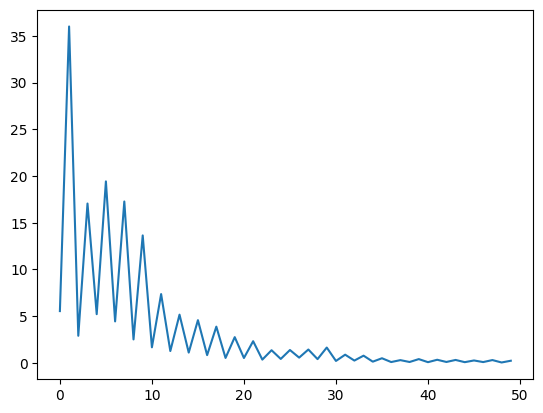

In [35]:
plt.plot(lamdaib)

In [524]:
(pos* data_df['mid'])[pos.diff() != 0]

0           0.000
96        311.775
399         0.000
432       311.875
465         0.000
           ...   
312613    311.175
314477      0.000
316989    311.075
318763      0.000
318764    311.075
Length: 546, dtype: float64

In [522]:
(pos.diff().fillna(0) * data_df['mid'])

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
320306    0.0
320307    0.0
320308    0.0
320309    0.0
320310    0.0
Length: 320311, dtype: float64

In [506]:
(pos * data_df['mid']).sum()

311.6749999999994

In [ ]:
data_df[data_df['ris']]

In [480]:
pos.value_counts()

rise_prob
 0.0    319765
 1.0       273
-1.0       273
Name: count, dtype: int64

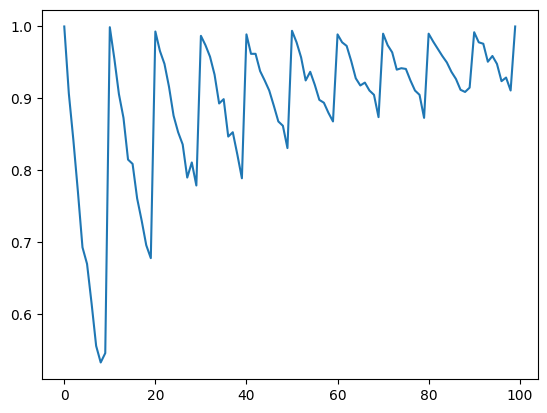

In [36]:
plt.plot(disbalance_to_prob.values())

In [30]:
def get_prob(rel):
    if int(rel) < 10:
        return res[rel]
    else: return res[-1]
    
get_prob = np.vectorize(get_prob)

In [31]:
get_prob(20)

array(0.474)

In [33]:
data_df['incr'] = data_df['mid'].diff() > 0
data_df['probs'] = (data_df['VBID0'] / data_df['VASK0']).apply(lambda x: res[int(x)] if x <10 else res[-1])

In [100]:
N = 2000
pearsonr(data_df['mid'].head(N), data_df['probs'].head(N))

PearsonRResult(statistic=0.21936579255260052, pvalue=3.230196606361599e-23)

In [68]:
data_df[['mid', 'probs']].head(2000)

,mid,probs
0,311.825,0.475
1,311.825,0.475
2,311.825,0.475
3,311.825,0.475
4,311.825,0.475
...,...,...
1995,312.125,0.485
1996,312.125,0.485
1997,312.125,0.485
1998,312.125,0.485


In [106]:
pos = data_df['mid'] * -1 * (data_df['probs'] < 0.5)

In [166]:
pos = (data_df['probs'] > 0.5).astype(int)

In [180]:
pos = pos.replace({0: -1})

In [181]:
pos

0        -1
1        -1
2        -1
3        -1
4        -1
         ..
324184   -1
324185   -1
324186   -1
324187   -1
324188   -1
Name: probs, Length: 324189, dtype: int64